In [1]:
import os, glob
import numpy as np
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy.units as u
from tqdm.auto import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore", category=u.UnitsWarning)
warnings.filterwarnings("ignore", category=fits.verify.VerifyWarning)

In [33]:
project_name = "kbonus-apexba"

ap_names = [0, 1, 2, 3, 4, 5, 6, 7]
ap_percut = ["op", 0 , 15, 30, 45, 60, 75, 90]

columns = [
    "TIME",
    "CADENCENO",
    "FLUX",
    "FLUX1",
    "FLUX2",
    "FLUX3",
    "FLUX4",
    "FLUX5",
    "FLUX6",
    "FLUX7",
    "FLUX_ERR",
    "FLUX_ERR1",
    "FLUX_ERR2",
    "FLUX_ERR3",
    "FLUX_ERR4",
    "FLUX_ERR5",
    "FLUX_ERR6",
    "FLUX_ERR7",
    "QUALITY",
    "SAP_QUALITY",
]

In [3]:
quarters = np.arange(5, 18)
channels = np.delete(np.arange(1, 85, 1), [4,5,6,7])
quarters, channels

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 array([ 1,  2,  3,  4,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]))

In [4]:
cat = Table.read("../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_v1.0_cat.fits")#.to_pandas().set_index("Gaia_designation")

In [85]:
u.day

Unit("electron / s")

# rebuild directory tree and LCs

In [108]:
for q in tqdm(quarters):
    for ch in tqdm(channels):
        in_dir = "../../EXBA_LCFs/data/q%02i/ch%02i" % (q, ch)
        files = np.sort(glob.glob("%s/hlsp_kbonus-apexba_kepler_*-q%02i_v1.0_lc.fits.gz" % (in_dir, q)))
        for i, f in tqdm(enumerate(files), total=len(files), leave=False):
            hdu = fits.open(f)
            # update header cards
            designation = hdu[0].header["OBJECT"]

            hdu[0].header.set("DOI", "10.17909/t9-d5wy-e535", 
                     "Digital Object Identifier for the HLSP data collection", 
                     before="ORIGIN")
            hdu[0].header.set("FILTER", "KEPLER", "", after="INSTRUME")
            hdu[0].header.set("TIMESYS", "TDB", "Time scale", after="FILTER")
            
            new_table = Table(hdu[1].data)
            
            for col in columns:
                if col.startswith("FLUX"):
                    new_table[col].unit = "e-/s"
                if col == "TIME":
                    new_table[col] -= 2454833
                    new_table[col].unit = "BJD - 2454833"

            hdu[1] = fits.BinTableHDU(new_table[columns], name="LIGHTCURVE")
            
            # aperture metrics
            for k, ap in enumerate(ap_names):
                hdu[0].header.set("PERCUT%i" % ap, 
                                  np.round(hdu[0].header["PERCUT%i" % ap], decimals=1), 
                                  "Percentile cut to define aperture %i" % ap)
                hdu[0].header.set("FLFRSAP%i" % ap, 
                                  np.round(hdu[0].header["FLFRSAP%i" % ap], decimals=5), 
                                  "Flux completeness metric for aperture %i" % ap)
                hdu[0].header.set("CRWDSAP%i" % ap, 
                                  np.round(hdu[0].header["CRWDSAP%i" % ap], decimals=5), 
                                  "Flux crowding metric for aperture %i" % ap)
                if ap == 0:
                    del hdu[0].header["PERCUT%i" % ap]

            # new dir tree
            out_dir = "../../EXBA_LCFs/data_v2/q%02i/ch%02i" % (q, ch)
            if not os.path.isdir(out_dir):
                os.makedirs(out_dir)
            # new file name
            fname = "hlsp_kbonus-apexba_kepler_kepler_%s-q%02i_kepler_v1.0_lc.fits" % (
                        designation.replace(" ", "-").lower(),
                        q,
                    )
            hdu.writeto("%s/%s" % (out_dir, fname), overwrite=True, checksum=True)
        # break
    break

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

  0%|          | 0/141 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/212 [00:00<?, ?it/s]

  0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/84 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

# test new files

In [92]:
fname = "../../EXBA_LCFs/data_v2/q05/ch01/hlsp_kbonus-apexba_kepler_kepler_gaia-edr3-2105386822405410048-q05_kepler_v1.0_lc.fits"

test_hdu = fits.open(fname)

In [93]:
test_hdu.info()

Filename: ../../EXBA_LCFs/data_v2/q05/ch01/hlsp_kbonus-apexba_kepler_kepler_gaia-edr3-2105386822405410048-q05_kepler_v1.0_lc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      81   ()      
  1  LIGHTCURVE    1 BinTableHDU     68   4492R x 20C   [D, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, J]   
  2  APERTURE_OPT    1 ImageHDU        10   (36, 60)   uint8   
  3  APERTURE_1    1 ImageHDU        10   (36, 60)   uint8   
  4  APERTURE_2    1 ImageHDU        10   (36, 60)   uint8   
  5  APERTURE_3    1 ImageHDU        10   (36, 60)   uint8   
  6  APERTURE_4    1 ImageHDU        10   (36, 60)   uint8   
  7  APERTURE_5    1 ImageHDU        10   (36, 60)   uint8   
  8  APERTURE_6    1 ImageHDU        10   (36, 60)   uint8   
  9  APERTURE_7    1 ImageHDU        10   (36, 60)   uint8   


In [94]:
test_hdu[0].header

SIMPLE  =                    T / conforms to FITS standards                     
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T / file contains extensions                       
NEXTEND =                    2 / number of standard extensions                  
EXTNAME = 'PRIMARY '           / name of extension                              
EXTVER  =                    1 / extension version number (not format version)  
HLSPID  = '' / The identifier (acronym) for this HLSP collection                
HLSPLEAD= 'Jorge Martinez-Palomera' / Full name of HLSP project lead            
HLSPVER = '1.0     '           / HLSP version                                   
LICENSE = 'CC BY 4.0'                                                           
LICENURL= 'https://creativecommons.org/licenses/by/4.0/'                        
DOI     = '10.17909/t9-d5wy-

In [95]:
test_hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   92 / length of dimension 1                          
NAXIS2  =                 4492 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   20 / number of table fields                         
EXTNAME = 'LIGHTCURVE'         / extension name                                 
TTYPE1  = 'TIME    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'BJD - 2454833'                                                       
TTYPE2  = 'CADENCENO'       

In [96]:
lc = lk.KeplerLightCurve.read(fname)

In [97]:
lc.time

<Time object: scale='tdb' format='bkjd' value=[443.49088301 443.51131743 443.53175164 ... 538.10160744 538.12204151
 538.16290934]>

In [98]:
lc.flux

<Quantity [2104.549 , 2101.1702, 2103.225 , ..., 2072.4094, 2063.3303,
           2061.4746] electron / s>

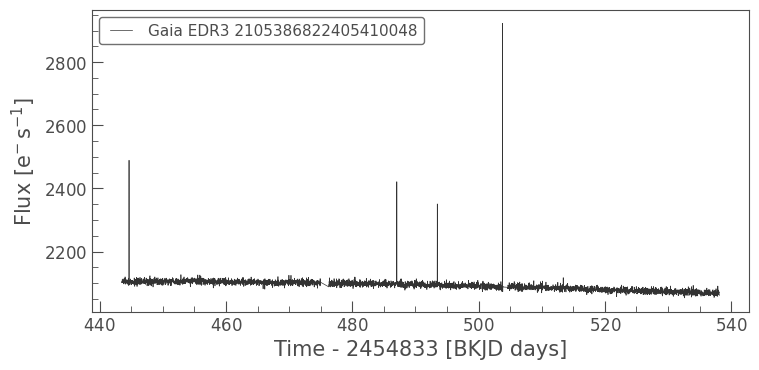

In [79]:
ax = lc.plot()

In [311]:
fits.open("/Users/jorgemarpa/Work/BAERI/ADAP/kepler-workflow/notebooks/lcs/Kepler/kplr008362616-2010174085026_llc.fits")[1].header

XTENSION= 'BINTABLE'           / marks the beginning of a new HDU               
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100 / length of first array dimension                
NAXIS2  =                 4634 / length of second array dimension               
PCOUNT  =                    0 / group parameter count (not used)               
GCOUNT  =                    1 / group count (not used)                         
TFIELDS =                   20 / number of table fields                         
TTYPE1  = 'TIME    '           / column title: data time stamps                 
TFORM1  = 'D       '           / column format: 64-bit floating point           
TUNIT1  = 'BJD - 2454833'      / column units: barycenter corrected JD          
TDISP1  = 'D14.7   '           / column display format                          
TTYPE2  = 'TIMECORR'        

# Support Files

In [29]:
del_kw = ["PMRA",
"PMDEC",
"PMTOTAL",
"PARALLAX",
"GLON",
"GLAT",
"GMAG",
"RMAG",
"IMAG",
"ZMAG",
"D51MAG",
"JMAG",
"HMAG",
"KMAG",
"KEPMAG",
"GRCOLOR",
"JKCOLOR",
"GKCOLOR",
"TEFF",
"LOGG",
"FEH",
"EBMINUSV",
"AV",
"RADIUS",
"TMINDEX",
"SCPID"]

for q in tqdm(quarters):
    for ch in channels:
        in_dir = "../../EXBA_LCFs/data/q%02i/ch%02i" % (q, ch)
        path = "%s/hlsp_kbonus-apexba_kepler_exba-mask-ch%02i-q%02i_v1.0_sup.fits.gz" % (in_dir, ch, q)
        hdu = fits.open(path)
        
        del hdu[1].header["TFORM1"], hdu[1].header["TTYPE1"], hdu[1].header["TUNIT1"]
        
        new_tab = Table.read(path)
        new_tab["ra"].unit = "deg"
        new_tab["ra_error"].unit = "mas"
        new_tab["dec"].unit = "deg"
        new_tab["dec_error"].unit = "mas"
        new_tab["pmra"].unit = "mas / yr"
        new_tab["pmdec"].unit = "mas / yr"
        new_tab["parallax"].unit = "mas"
        new_tab["parallax_error"].unit = "mas"
        new_tab["col"].unit = "pixel"
        new_tab["row"].unit = "pixel"
        new_tab.rename_column("designation", "Gaia_ID")
        new_tab.rename_column("col", "EXBA_column")
        new_tab.rename_column("row", "EXBA_row")
        
        for col in new_tab.columns:
            if "flux" in col:
                new_tab[col].unit = "e-/s"
            if "mag" in col:
                new_tab[col].unit = "mag"
        hdu[2] = fits.BinTableHDU(new_tab)
        
        # new dir tree
        out_dir = "../../EXBA_LCFs/data_v2/q%02i/ch%02i" % (q, ch)
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        # new file name
        fname = "hlsp_kbonus-apexba_kepler_kepler_exba-mask-ch%02i-q%02i_kepler_v1.0_sup.fits" % (
                    ch,
                    q,
                )
        hdu.writeto("%s/%s" % (out_dir, fname), overwrite=True, checksum=True)
    #     break
    # break

  0%|          | 0/13 [00:00<?, ?it/s]

In [20]:
hdu.info()

Filename: ../../EXBA_LCFs/data/q05/ch01/hlsp_kbonus-apexba_kepler_exba-mask-ch01-q05_v1.0_sup.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1  EXBA_mask     1 ImageHDU        11   (36, 60)   float32   
  2  EXBA_sources    1 BinTableHDU     70   38R x 24C   ['29A', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'K', 'D', 'D', 'D', 'K', 'D', 'D', 'D', 'K', 'D', 'D', 'D', 'D', 'D', 'K']   


In [21]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   36                                                  
NAXIS2  =                   60                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
DATE    = '2021-04-20'                                                          
CHECKSUM= '2IKA29IA2GIA29IA'   / HDU checksum updated 2021-09-23T19:34:05       
DATASUM = '183586843'          / data unit checksum updated 2021-09-23T19:34:05 
EXTNAME = 'EXBA_mask'                                                           

In [25]:
hdu[2].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  213 / length of dimension 1                          
NAXIS2  =                   38 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   24 / number of table fields                         
GAIA_DR =                    3                                                  
CHECKSUM= '4I1e6I1e4I1e4I1e'   / HDU checksum updated 2021-09-23T19:34:51       
DATASUM = '226384346'          / data unit checksum updated 2021-09-23T19:34:51 
EXTNAME = 'EXBA_sources'                                                        
TTYPE1  = 'Gaia_ID '        

In [14]:
fits.open("../../EXBA_LCFs/data_v2/q05/ch01/hlsp_kbonus-apexba_kepler_kepler_exba-mask-ch01-q05_kepler_v1.0_sup.fits").info()

Filename: ../../EXBA_LCFs/data_v2/q05/ch01/hlsp_kbonus-apexba_kepler_kepler_exba-mask-ch01-q05_kepler_v1.0_sup.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   ()      
  1  EXBA_mask     1 ImageHDU        11   (36, 60)   float32   
  2  EXBA_sources    1 BinTableHDU     70   38R x 24C   [29A, D, D, D, D, D, D, D, D, K, D, D, D, K, D, D, D, K, D, D, D, D, D, K]   


In [27]:
tab = Table.read("../../EXBA_LCFs/data_v2/q05/ch01/hlsp_kbonus-apexba_kepler_kepler_exba-mask-ch01-q05_kepler_v1.0_sup.fits")
tab[:10]

Gaia_ID,ra,ra_error,dec,dec_error,pmra,pmdec,parallax,parallax_error,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_mag,EXBA_column,EXBA_row,clean_flag
,deg,mas,deg,mas,mas / yr,mas / yr,mas,mas,,e-/s,e-/s,mag,,e-/s,e-/s,mag,,e-/s,e-/s,mag,pix,pix,
bytes29,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
Gaia EDR3 2105384211065299328,282.02601422275194,0.19085671,44.25377944557144,0.22391872,-19.973062525408807,-18.944104549054543,0.5892298715885553,0.22106487,381,299.7253029271898,0.8599534,19.495558,35,80.53954295941575,6.2322636,20.573519,38,333.1837408698047,8.763941,18.441187,589.6270633069905,564.8003895381436,0
Gaia EDR3 2105384241127278208,282.00675214953424,0.13252868,44.25354519592058,0.15323067,-1.7719406349189692,-2.5299803589776717,0.1500959224388817,0.15502745,400,445.3054402667451,0.9397699,19.065722,44,212.495879567831,8.967708,19.520166,42,319.30774995602985,8.512412,18.487371,581.9344566234053,574.6431303056459,0
Gaia EDR3 2105384245425035392,282.0141527165855,0.05810274,44.25357179111208,0.06556623,-1.1884323904997922,-1.3311902001283102,0.6496634574414855,0.06638684,406,1588.2213028971023,1.4349111,17.68509,42,579.377437978047,9.663919,18.431139,46,1368.9923786653862,8.267079,16.906893,584.9348779472202,570.8978329885136,0
Gaia EDR3 2105384245425036032,282.0115846417504,0.046779666,44.25693434951504,0.052581493,-0.1485608838175161,2.350118651573734,0.4188690082459329,0.052441496,401,2265.1344000992094,1.631512,17.299631,47,1072.065379414982,11.900966,17.762989,47,1652.775605621007,9.110782,16.70236,581.5212718202167,570.2769158032179,0
Gaia EDR3 2105384275487021696,282.01759328547774,0.11267807,44.257040875289896,0.13129382,-3.5800351772400383,-7.079612589511583,0.0743769441101454,0.12939464,399,582.0286158555485,1.0321914,18.775005,45,314.7679254390559,9.323002,19.093567,44,396.87320392034536,7.354785,18.251266,583.8973054559013,567.1877236839633,0
Gaia EDR3 2105384275487028864,282.022582665752,0.22320406,44.26418381452679,0.26284742,-2.499486775535332,-6.307408380364082,0.0193874303894036,0.2625386,404,216.9472501967879,0.7336519,19.846481,43,115.15200428632411,6.7880244,20.185364,42,164.2429781732355,5.605481,19.209179,580.9058758605402,560.6047885883868,0
Gaia EDR3 2105384275487765888,282.01554846672286,0.25413236,44.26914439033675,0.29134235,0.3888750505490295,-7.9497518322893,0.4233887386813281,0.2960355,381,197.14257043284368,0.72848296,19.950417,32,71.95551194174189,5.6119547,20.695883,39,194.9146284235735,7.0755024,19.023285,574.5465844516351,561.3245079922403,0
Gaia EDR3 2105384279784776448,282.0092266244273,0.054246727,44.26875069041165,0.061871875,-6.340516887731038,-7.520252684424294,0.0962676785583503,0.061771583,427,1706.8101283696064,1.416225,17.606903,48,957.8780200952529,8.470039,17.885267,48,1095.6133562745351,9.330917,17.148752,572.2452957511196,564.7344209661726,0


# Full catalog 

In [267]:
hdu = fits.open("../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_v1.0_cat.fits")

In [268]:
hdu.info()

Filename: ../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_v1.0_cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   ()      
  1  EXBA-sources    1 BinTableHDU    104   9327R x 23C   [29A, D, D, D, D, D, D, D, D, D, D, D, J, E, E, E, E, E, E, E, E, E, D]   


In [269]:
hdu[0].header.set("EQUINOX", 2000.0, "Equinox of the celestial coordinate system")

In [270]:
hdu[0].header

SIMPLE  =                    T / Standard FITS format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No image, just extensions                      
EXTEND  =                    T / There are standard extensions                  
DOI     = '' / Digital Object Identifier for the HLSP data collection           
EQUINOX =               2000.0 / Equinox of the celestial coordinate system     
HLSPID  = 'kbonus-apexba'      / The identifier for this HLSP collection        
HLSPLEAD= 'Jorge Martinez-Palomera' / Full name of HLSP project lead            
HLSPNAME= 'Kepler Bonus: Aperture EXBA' / Title for HLSP project, long form     
HLSPTARG= 'Kepler EXBA'        / Designation of the field(s) for this HLSP      
HLSPVER = '1.0     '           / HLSP version                                   
OBSERVAT= 'Kepler  '           / Observatory used to obtain this observation    
TELESCOP= 'Kepler  '        

In [256]:
source_list = Table.read("../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_v1.0_cat.fits", )
for col in source_list.columns:
    if col == "Gaia_designation": continue
    print(col)
    try:
        source_list[col][source_list[col] == 1e20] = np.nan
        source_list[col].mask = ~np.isfinite(source_list[col])
    except ValueError:
        continue
try:
    source_list.rename_column('Gaia_designation', 'Gaia ID')
except:
    pass
    
hdu0 = fits.open("../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_v1.0_cat.fits")[0]
hdu1_h = fits.open("../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_v1.0_cat.fits")[0].header
hdu_tab = fits.BinTableHDU(source_list, name="EXBA-SOURCE-LIST")

for kwi in range(1, 24):
    if "TCOMM%i" % kwi in list(hdu1_h.keys()):
        hdu_tab.header.set("TCOMM%i" % kwi, hdu1_h["TCOMM%i" % kwi], after="TUNIT%i" % kwi)
    else:
        continue

hdul = fits.HDUList([hdu0, hdu_tab])

hdul.writeto("test.fits", overwrite=True, checksum=True)

ra
ra_error
dec
dec_error
pmra
pmdec
parallax
parallax_error
phot_g_mean_mag
phot_bp_mean_mag
phot_rp_mean_mag
KIC
umag
gmag
rmag
imag
zmag
Jmag
Hmag
Kmag
kepmag
angDist


In [262]:
hdul_new = fits.open("test_2.fits")

In [264]:
del hdul_new[1].header["STILVERS"], hdul_new[1].header["STILCLAS"]

In [266]:
hdul_new[1].data

FITS_rec([('Gaia EDR3 2105384211065299328', 282.02601422, 0.19085671, 44.25377945, 0.22391872, -19.97306253, -18.94410455, 0.58922987, 0.22106487, 19.495558, 20.573519, 18.441187,     8278800, nan,    nan, 19.63 , 18.36 ,    nan,    nan,    nan,    nan, 19.63 , 0.456638),
          ('Gaia EDR3 2105384241127278208', 282.00675215, 0.13252868, 44.2535452 , 0.15323067,  -1.77194063,  -2.52998036, 0.15009592, 0.15502745, 19.065722, 19.520166, 18.487371,     8278766, nan, 19.869, 19.221, 18.988,    nan,    nan,    nan,    nan, 19.254, 0.326691),
          ('Gaia EDR3 2105384245425035392', 282.01415272, 0.05810274, 44.25357179, 0.06556623,  -1.18843239,  -1.3311902 , 0.64966346, 0.06638684, 17.68509 , 18.431139, 16.906893,     8278780, nan, 18.595, 17.742, 17.418,    nan, 15.89 , 15.292, 15.129, 17.772, 0.285838),
          ...,
          ('Gaia EDR3 2143714973114706560', 282.74053037, 0.02152255, 48.26248902, 0.02269474,  -3.18832027,  -5.86677478, 0.58844043, 0.02325262, 15.417315, 15.77796

In [272]:
hdu[0].header

SIMPLE  =                    T / Standard FITS format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No image, just extensions                      
EXTEND  =                    T / There are standard extensions                  
DOI     = '' / Digital Object Identifier for the HLSP data collection           
EQUINOX =               2000.0 / Equinox of the celestial coordinate system     
HLSPID  = 'kbonus-apexba'      / The identifier for this HLSP collection        
HLSPLEAD= 'Jorge Martinez-Palomera' / Full name of HLSP project lead            
HLSPNAME= 'Kepler Bonus: Aperture EXBA' / Title for HLSP project, long form     
HLSPTARG= 'Kepler EXBA'        / Designation of the field(s) for this HLSP      
HLSPVER = '1.0     '           / HLSP version                                   
OBSERVAT= 'Kepler  '           / Observatory used to obtain this observation    
TELESCOP= 'Kepler  '        

In [273]:
final_hdul = fits.HDUList([hdu[0], hdul_new[1]])

final_hdul.writeto("../../EXBA_LCFs/data_v2/hlsp_kbonus-apexba_kepler_kepler_source-list_kepler_v1.0_cat.fits", 
                   overwrite=True, checksum=True)

In [275]:
test_cat = fits.open("../../EXBA_LCFs/data_v2/hlsp_kbonus-apexba_kepler_kepler_source-list_kepler_v1.0_cat.fits")

In [276]:
test_cat.info()

Filename: ../../EXBA_LCFs/data_v2/hlsp_kbonus-apexba_kepler_kepler_source-list_kepler_v1.0_cat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      24   ()      
  1  EXBA-SOURCE-LIST    1 BinTableHDU    103   9327R x 23C   [29A, D, D, D, D, D, D, D, D, D, D, D, J, E, E, E, E, E, E, E, E, E, D]   


In [277]:
test_cat[0].header

SIMPLE  =                    T / Standard FITS format                           
BITPIX  =                    8 / Character data                                 
NAXIS   =                    0 / No image, just extensions                      
EXTEND  =                    T / There are standard extensions                  
DOI     = '' / Digital Object Identifier for the HLSP data collection           
EQUINOX =               2000.0 / Equinox of the celestial coordinate system     
HLSPID  = 'kbonus-apexba'      / The identifier for this HLSP collection        
HLSPLEAD= 'Jorge Martinez-Palomera' / Full name of HLSP project lead            
HLSPNAME= 'Kepler Bonus: Aperture EXBA' / Title for HLSP project, long form     
HLSPTARG= 'Kepler EXBA'        / Designation of the field(s) for this HLSP      
HLSPVER = '1.0     '           / HLSP version                                   
OBSERVAT= 'Kepler  '           / Observatory used to obtain this observation    
TELESCOP= 'Kepler  '        

In [278]:
test_cat[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  165 / width of table in bytes                        
NAXIS2  =                 9327 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   23 / number of columns                              
EXTNAME = 'EXBA-SOURCE-LIST'   / table name                                     
TTYPE1  = 'Gaia_ID '           / label for column 1                             
TFORM1  = '29A     '           / format for column 1                            
TCOMM1  = 'Gaia designation ID'                                                 
TTYPE2  = 'ra      '        

In [36]:
df = Table.read("../../EXBA_LCFs/data/hlsp_kbonus-apexba_kepler_kepler_source-list_kepler_v1.0_cat.fits").to_pandas()

In [37]:
import matplotlib.pyplot as plt

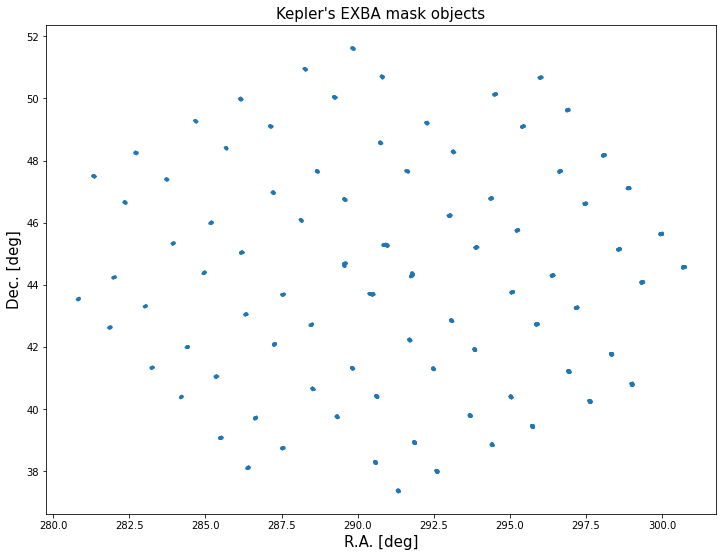

In [44]:
plt.figure(figsize=(12,9))
plt.title("Kepler's EXBA mask objects", fontsize=15)
plt.scatter(df.ra, df.dec, s=1, alpha=.6)
plt.xlabel("R.A. [deg]", fontsize=15)
plt.ylabel("Dec. [deg]", fontsize=15)
plt.savefig("../../EXBA_LCFs/sky_map.png", bbox_inches="tight")
plt.show()